# Ohm's Law
Author: Louis Richard\
Compute the terms in the generalized Ohm's law equation: Ion convection, Hall, and electron pressure divergence terms. Hall and pressure terms are computed using four-spacecraft methods. The observed electric fields and convection terms are averaged over the four spacecraft. Terms computed in GSE coordinates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import constants
from pyrfu.mms import get_data
from pyrfu.plot import plot_line
from pyrfu.pyrf import (resample, avg_4sc, extend_tint, cross, c_4_grad, 
                        ts_vec_xyz, c_4_j)

### Define time interval

In [2]:
tint = ["2015-10-30T05:15:40.000", "2015-10-30T05:15:55.000"]
tint_long = extend_tint(tint, [-60, 60])

## Load all data and constants

### Define constants

In [3]:
qe = constants.e.value
me = constants.m_e.value

### Load FPI data

In [4]:
n_mms_e = [get_data("ne_fpi_brst_l2", tint, i) for i in range(1, 5)]
v_mms_e = [get_data("ve_gse_fpi_brst_l2", tint, i) for i in range(1, 5)]
p_mms_e = [get_data("pe_gse_fpi_brst_l2", tint, i) for i in range(1, 5)]

n_mms_i = [get_data("ni_fpi_brst_l2", tint, i) for i in range(1, 5)]
v_mms_i = [get_data("vi_gse_fpi_brst_l2", tint, i) for i in range(1, 5)]

Loading mms1_des_numberdensity_brst...
Loading mms2_des_numberdensity_brst...
Loading mms3_des_numberdensity_brst...
Loading mms4_des_numberdensity_brst...
Loading mms1_des_bulkv_gse_brst...
Loading mms2_des_bulkv_gse_brst...
Loading mms3_des_bulkv_gse_brst...
Loading mms4_des_bulkv_gse_brst...
Loading mms1_des_prestensor_gse_brst...
Loading mms2_des_prestensor_gse_brst...
Loading mms3_des_prestensor_gse_brst...
Loading mms4_des_prestensor_gse_brst...
Loading mms1_dis_numberdensity_brst...
Loading mms2_dis_numberdensity_brst...
Loading mms3_dis_numberdensity_brst...
Loading mms4_dis_numberdensity_brst...
Loading mms1_dis_bulkv_gse_brst...
Loading mms2_dis_bulkv_gse_brst...
Loading mms3_dis_bulkv_gse_brst...
Loading mms4_dis_bulkv_gse_brst...


### Load FGM data

In [5]:
b_mms = [get_data("b_gse_fgm_brst_l2", tint, i) for i in range(1, 5)]

Loading mms1_fgm_b_gse_brst_l2...
Loading mms2_fgm_b_gse_brst_l2...
Loading mms3_fgm_b_gse_brst_l2...
Loading mms4_fgm_b_gse_brst_l2...


### Load spacecraft position

In [6]:
r_mms = [get_data("R_gse", tint_long, i) for i in range(1, 5)]

Loading mms1_mec_r_gse...
Loading mms2_mec_r_gse...
Loading mms3_mec_r_gse...
Loading mms4_mec_r_gse...


### Load Electric field

In [7]:
e_mms = [get_data("e_gse_edp_brst_l2", tint, i) for i in range(1, 5)]

Loading mms1_edp_dce_gse_brst_l2...
Loading mms2_edp_dce_gse_brst_l2...
Loading mms3_edp_dce_gse_brst_l2...
Loading mms4_edp_dce_gse_brst_l2...


## Resample and compute averages

In [8]:
n_mms_e = [resample(n_e, n_mms_e[0]) for n_e in n_mms_e]
v_mms_e = [resample(v_xyz_e, n_mms_e[0]) for v_xyz_e in v_mms_e]
p_mms_e = [resample(p_xyz_e, n_mms_e[0]) for p_xyz_e in p_mms_e]
n_mms_i = [resample(n_i, n_mms_e[0]) for n_i in n_mms_i]
v_mms_i = [resample(v_xyz_i, n_mms_e[0]) for v_xyz_i in v_mms_i]
r_mms = [resample(r_xyz, n_mms_e[0]) for r_xyz in r_mms]
b_mms = [resample(b_xyz, n_mms_e[0]) for b_xyz in b_mms]
e_mms = [resample(e_xyz, n_mms_e[0]) for e_xyz in e_mms]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyrfu/pyrf/resample.py:175: UserWarning: Using averages in resample
  warnings.warn("Using averages in resample", UserWarning)


In [9]:
n_e_avg = avg_4sc(n_mms_e)
b_xyz_avg = avg_4sc(b_mms)
e_xyz_avg = avg_4sc(e_mms)

## Compute convection terms

### Compute ion convection term (MMS average)

In [10]:
evxb_mms_i = [1e-3 * cross(v_xyz_i, b_xyz) for v_xyz_i, b_xyz in zip(v_mms_i, b_mms)]
evxb_xyz_i = avg_4sc(evxb_mms_i)

### Compute electron convection term (MMS average)

In [11]:
evxb_mms_e = [1e-3 * cross(v_xyz_e, b_xyz) for v_xyz_e, b_xyz in zip(v_mms_e, b_mms)]
evxb_xyz_e = avg_4sc(evxb_mms_e)

## Compute pressure divergence term

In [12]:
p_mms_xx = [1e-9 * p_xyz[:, 0, 0] for p_xyz in p_mms_e]
p_mms_yy = [1e-9 * p_xyz[:, 1, 1] for p_xyz in p_mms_e]
p_mms_zz = [1e-9 * p_xyz[:, 2, 2] for p_xyz in p_mms_e]
p_mms_xy = [1e-9 * p_xyz[:, 0, 1] for p_xyz in p_mms_e]
p_mms_xz = [1e-9 * p_xyz[:, 0, 2] for p_xyz in p_mms_e]
p_mms_yz = [1e-9 * p_xyz[:, 1, 2] for p_xyz in p_mms_e]

In [13]:
ep_xyz_xx = c_4_grad(r_mms, p_mms_xx, "grad")
ep_xyz_yy = c_4_grad(r_mms, p_mms_yy, "grad")
ep_xyz_zz = c_4_grad(r_mms, p_mms_zz, "grad")
ep_xyz_xy = c_4_grad(r_mms, p_mms_xy, "grad")
ep_xyz_xz = c_4_grad(r_mms, p_mms_xz, "grad")
ep_xyz_yz = c_4_grad(r_mms, p_mms_yz, "grad")

In [14]:
ep_x = -(ep_xyz_xx[:, 0] + ep_xyz_xy[:, 1] + ep_xyz_xz[:, 2]) / (n_e_avg * 1e6 * qe)
ep_y = -(ep_xyz_xy[:, 0] + ep_xyz_yy[:, 1] + ep_xyz_yz[:, 2]) / (n_e_avg * 1e6 * qe)
ep_z = -(ep_xyz_xz[:, 0] + ep_xyz_yz[:, 1] + ep_xyz_zz[:, 2]) / (n_e_avg * 1e6 * qe)

In [15]:
ep_xyz = ts_vec_xyz(ep_xyz_xx.time.data, np.vstack([ep_x.data, ep_y.data, ep_z.data]).T)

### Compute Hall term and current density using curlometer

In [16]:
j_xyz, div_b, b_xyz, jxb_xyz, div_t_shear, div_pb = c_4_j(r_mms, b_mms)
jxb_xyz.data /= n_e_avg.data[:, None] * qe * 1e3 * 1e9
j_xyz.data *= 1e9

In [17]:
e_lhs = ts_vec_xyz(e_xyz_avg.time.data, e_xyz_avg.data - evxb_xyz_i.data)
e_rhs = ts_vec_xyz(e_xyz_avg.time.data,jxb_xyz.data + ep_xyz.data);

## Plot figure

In [18]:
legend_options = dict(ncol=3, loc="upper right", frameon=True)

<IPython.core.display.Javascript object>


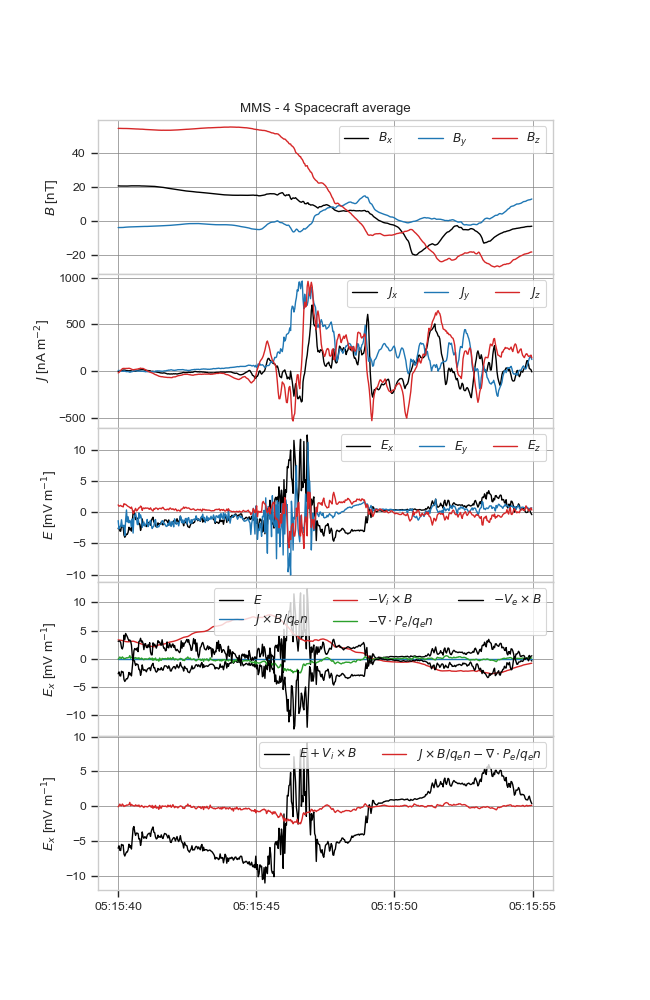

Text(0.5, 1.0, 'MMS - 4 Spacecraft average')

In [19]:
%matplotlib notebook
f, axs = plt.subplots(5, sharex="all", figsize=(6.5, 10))
f.subplots_adjust(hspace=0, left=.15, right=.85)

plot_line(axs[0], b_xyz_avg)
axs[0].set_ylabel("$B$ [nT]")
axs[0].legend(["$B_{x}$","$B_{y}$","$B_{z}$"], **legend_options)

plot_line(axs[1], j_xyz)
axs[1].set_ylabel("$J$ [nA m$^{-2}$]")
axs[1].legend(["$J_{x}$","$J_{y}$","$J_{z}$"], **legend_options)

plot_line(axs[2], e_xyz_avg)
axs[2].set_ylabel("$E$ [mV m$^{-1}$]")
axs[2].legend(["$E_{x}$","$E_{y}$","$E_{z}$"], **legend_options)

plot_line(axs[3], e_xyz_avg[:, 0])
plot_line(axs[3], jxb_xyz[:, 0])
plot_line(axs[3], evxb_xyz_i[:, 0])
plot_line(axs[3], ep_xyz[:, 0])
plot_line(axs[3], evxb_xyz_e[:, 0])
axs[3].set_ylabel("$E_x$ [mV m$^{-1}$]")
labels = ['$E$','$J \\times B/q_{e}n$','$-V_{i} \\times B$','$-\\nabla \\cdot P_{e}/q_{e}n$','$-V_{e} \\times B$']
axs[3].legend(labels, **legend_options)

plot_line(axs[4], e_lhs[:, 0], "k")
plot_line(axs[4], e_rhs[:, 0], "tab:red")
axs[4].set_ylabel("$E_x$ [mV m$^{-1}$]")
labels = ['$E+V_{i} \\times B$', '$J \\times B/q_{e}n - \\nabla \cdot P_{e}/q_{e}n$']
axs[4].legend(labels, **legend_options)

axs[0].set_title('MMS - 4 Spacecraft average')
